<a href="https://colab.research.google.com/github/PinRay22/BA/blob/main/week9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash
set -euxo pipefail

python -V
pip -V

# 清掉會衝突或你不需要的套件
pip uninstall -y bitsandbytes triton cudf-cu12 pylibcudf-cu12 dask-cudf-cu12 rmm-cu12 || true

# 基本工具
pip install -U pip setuptools wheel --quiet

# RAPIDS 常見相依：固定 pyarrow < 20，pandas < 2.2
pip install -U "pyarrow<20" "pandas<2.2" --quiet --no-warn-conflicts

# 安裝與本作業相容的版本（不含 bitsandbytes）
pip install -U \
  "transformers==4.45.2" \
  "datasets==2.20.0" \
  "accelerate==0.34.2" \
  "peft==0.13.2" \
  "evaluate==0.4.2" \
  "scikit-learn==1.4.2" \
  "matplotlib==3.8.4" \
  --quiet --no-warn-conflicts


Python 3.12.12
pip 25.3 from /usr/local/lib/python3.12/dist-packages/pip (python 3.12)
Found existing installation: bitsandbytes 0.43.3
Uninstalling bitsandbytes-0.43.3:
  Successfully uninstalled bitsandbytes-0.43.3
Found existing installation: triton 3.4.0
Uninstalling triton-3.4.0:
  Successfully uninstalled triton-3.4.0


+ python -V
+ pip -V
+ pip uninstall -y bitsandbytes triton cudf-cu12 pylibcudf-cu12 dask-cudf-cu12 rmm-cu12
+ pip install -U pip setuptools wheel --quiet
+ pip install -U 'pyarrow<20' 'pandas<2.2' --quiet --no-warn-conflicts
+ pip install -U transformers==4.45.2 datasets==2.20.0 accelerate==0.34.2 peft==0.13.2 evaluate==0.4.2 scikit-learn==1.4.2 matplotlib==3.8.4 --quiet --no-warn-conflicts


In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)


CUDA: True


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
max_steps is given, it will override any value given in num_train_epochs


Trainable params:
trainable params: 1,132,544 || all params: 1,035,651,072 || trainable%: 0.1094


Step,Training Loss,Validation Loss,F1 Macro,F1 Weighted,Auroc Macro,Pr Auc Macro
100,1.365700,1.180915,0.328380,0.425544,0.632604,0.452018
200,1.039400,0.953390,0.516920,0.575427,0.719484,0.551277
300,0.700900,0.911381,0.539732,0.599671,0.748357,0.591444


Validation (small run): {
  "eval_loss": 0.9113812446594238,
  "eval_f1_macro": 0.5397323791496161,
  "eval_f1_weighted": 0.5996711834039701,
  "eval_auroc_macro": 0.74835701723575,
  "eval_pr_auc_macro": 0.5914437778913803,
  "eval_runtime": 7.6926,
  "eval_samples_per_second": 25.999,
  "eval_steps_per_second": 3.25,
  "epoch": 1.2
}
Test (small run): {
  "f1_macro": 0.5852025356975852,
  "f1_weighted": 0.6384411703718634,
  "auroc_macro": 0.8056816787073101,
  "pr_auc_macro": 0.6484594987277769
}

=== Classification Report (Test, small) ===
              precision    recall  f1-score   support

    low_risk     0.7025    0.8416    0.7658       101
    mid_risk     0.4444    0.3902    0.4156        41
   high_risk     0.6744    0.5000    0.5743        58

    accuracy                         0.6500       200
   macro avg     0.6071    0.5773    0.5852       200
weighted avg     0.6414    0.6500    0.6384       200


Confusion Matrix:
 [[85  9  7]
 [18 16  7]
 [18 11 29]]


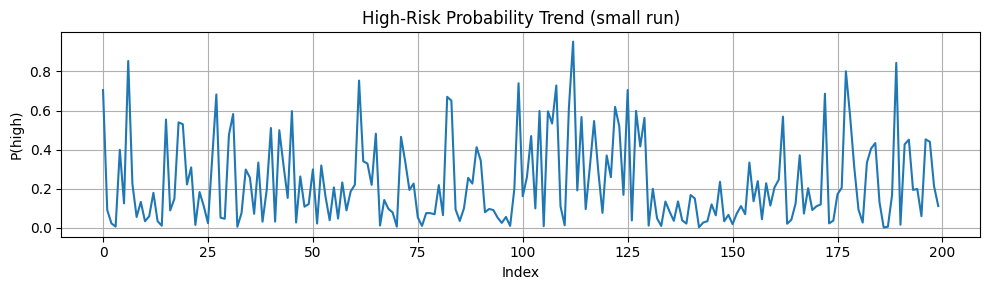

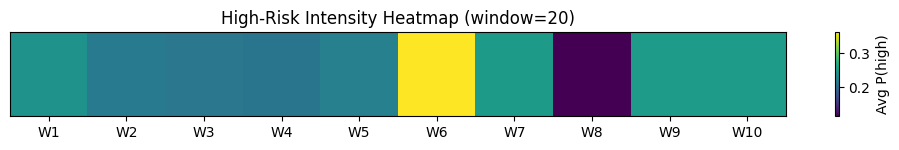

In [ ]:
# ========= Fast Dev Run：極速小訓練，驗證整體流程 =========
import os, math, random, json, numpy as np, torch
from datasets import load_dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, TrainingArguments, Trainer)
from peft import LoraConfig, get_peft_model
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

print("CUDA:", torch.cuda.is_available())

SEED=42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# ==== 極速參數（可之後放大）====
MODEL_NAME   = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"  # 更穩可用 "Qwen/Qwen2-0.5B"
MAX_LENGTH   = 96
BATCH_TRAIN  = 2
BATCH_EVAL   = 8
GRAD_ACCUM   = 1
EPOCHS       = 1
LR           = 2e-4
OUTPUT_DIR   = "/content/devrun_lora"
N_TRAIN, N_VAL, N_TEST = 500, 200, 200   # <<< 小資料量

# ==== Emotion → 3 類風險 ====
raw_ds = load_dataset("emotion")
label_names = raw_ds["train"].features["label"].names
name_to_risk = {"joy":0,"love":0,"surprise":0,"anger":1,"fear":1,"sadness":2}
id2label = {0:"low_risk",1:"mid_risk",2:"high_risk"}

def to_risk(ex):
    ex["risk_label"] = name_to_risk[label_names[ex["label"]]]
    return ex
ds = raw_ds.map(to_risk)

# 子集（打亂後取前 N）
def take_small(split, n):
    d = ds[split].shuffle(seed=SEED)
    if n is not None and n < len(d):
        d = d.select(range(n))
    return d

small_ds = {
    "train": take_small("train", N_TRAIN),
    "validation": take_small("validation", N_VAL),
    "test": take_small("test", N_TEST),
}

# ==== Tokenizer（補 pad）====
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
if tok.pad_token is None:
    tok.add_special_tokens({"pad_token": tok.eos_token})

def tok_fn(b):
    return tok(b["text"], truncation=True, max_length=MAX_LENGTH, padding=False)

from datasets import DatasetDict
tok_ds = DatasetDict({
    "train": small_ds["train"].map(tok_fn, batched=True, remove_columns=["text","label"]),
    "validation": small_ds["validation"].map(tok_fn, batched=True, remove_columns=["text","label"]),
    "test": small_ds["test"].map(tok_fn, batched=True, remove_columns=["text","label"]),
})
# 對齊 HF 預設標籤欄位名稱
tok_ds = tok_ds.rename_column("risk_label", "labels")

collator = DataCollatorWithPadding(tokenizer=tok, pad_to_multiple_of=8)

# ==== Base 模型 + LoRA（無 bitsandbytes）====
base = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else None,
    device_map="auto" if torch.cuda.is_available() else None
)
# 同步 pad 與 embedding 長度
base.resize_token_embeddings(len(tok))
base.config.pad_token_id = tok.pad_token_id
base.config.use_cache = False
if hasattr(base, "gradient_checkpointing_enable"):
    base.gradient_checkpointing_enable()

lora_cfg = LoraConfig(
    r=8, lora_alpha=16, lora_dropout=0.05,
    target_modules=["q_proj","v_proj"],  # 省顯存版本
    bias="none", task_type="SEQ_CLS",
)
model = get_peft_model(base, lora_cfg)
print("Trainable params:"); model.print_trainable_parameters()

# ==== 指標 ====
def metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
    preds = probs.argmax(axis=-1)
    out = {
        "f1_macro":    f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
    }
    try: out["auroc_macro"] = roc_auc_score(labels, probs, multi_class="ovr", average="macro")
    except: out["auroc_macro"] = float("nan")
    try: out["pr_auc_macro"] = average_precision_score(np.eye(3)[labels], probs, average="macro")
    except: out["pr_auc_macro"] = float("nan")
    return out

# ==== 訓練設定（快速）====
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy="steps",       # 每隔幾步就驗證一次，更快看到數字
    eval_steps=100,
    save_strategy="no",          # 不存 checkpoint，加速
    per_device_train_batch_size=BATCH_TRAIN,
    per_device_eval_batch_size=BATCH_EVAL,
    gradient_accumulation_steps=GRAD_ACCUM,
    num_train_epochs=EPOCHS,
    max_steps=300,               # <<< 強制只跑 300 steps（超快）
    learning_rate=LR,
    bf16=torch.cuda.is_available(),
    fp16=False,
    logging_steps=50,
    report_to="none"
)

trainer = Trainer(
    model=model, args=args,
    train_dataset=tok_ds["train"],
    eval_dataset=tok_ds["validation"],
    tokenizer=tok, data_collator=collator,
    compute_metrics=metrics
)

# ==== Train / Eval（小跑）====
trainer.train()
val_metrics = trainer.evaluate(tok_ds["validation"])
print("Validation (small run):", json.dumps(val_metrics, indent=2))

# ==== Test（小跑）====
pred = trainer.predict(tok_ds["test"])
logits = pred.predictions
probs  = torch.softmax(torch.tensor(logits), dim=-1).numpy()
y_true = np.array(tok_ds["test"]["labels"])     # <<< 修正：用 labels
y_pred = probs.argmax(axis=-1)

res = {
    "f1_macro":    f1_score(y_true, y_pred, average="macro"),
    "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
}
try: res["auroc_macro"] = roc_auc_score(y_true, probs, multi_class="ovr", average="macro")
except: res["auroc_macro"] = float("nan")
try: res["pr_auc_macro"] = average_precision_score(np.eye(3)[y_true], probs, average="macro")
except: res["pr_auc_macro"] = float("nan")
print("Test (small run):", json.dumps(res, indent=2))

print("\n=== Classification Report (Test, small) ===")
print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(3)], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
print("\nConfusion Matrix:\n", cm)

# ==== 小型可視化 ====
high = probs[:,2]
plt.figure(figsize=(10,3))
plt.plot(high); plt.grid(True)
plt.title("High-Risk Probability Trend (small run)"); plt.xlabel("Index"); plt.ylabel("P(high)")
plt.tight_layout(); plt.show()

win = max(20, len(high)//10)  # 視窗依樣本量調小
win_means = [high[i*win:(i+1)*win].mean() for i in range((len(high)+win-1)//win)]
heat = np.array(win_means)[None,:]
plt.figure(figsize=(10,1.6))
plt.imshow(heat, aspect="auto", cmap="viridis")
plt.colorbar(label="Avg P(high)")
plt.yticks([]); plt.xticks(range(heat.shape[1]), [f"W{i+1}" for i in range(heat.shape[1])])
plt.title(f"High-Risk Intensity Heatmap (window={win})")
plt.tight_layout(); plt.show()


CUDA available: True
Wed Nov  5 21:35:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P0             28W /   70W |    2246MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+--------------------------

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
max_steps is given, it will override any value given in num_train_epochs


Trainable params:
trainable params: 1,853,440 || all params: 1,036,371,968 || trainable%: 0.1788
Class weights: [0.74609375, 1.3125, 1.1171875]


Step,Training Loss,Validation Loss,F1 Macro,F1 Weighted,Auroc Macro,Pr Auc Macro
200,0.415800,0.426349,0.855950,0.863662,0.956977,0.920579
400,0.066500,0.328386,0.922841,0.928594,0.983697,0.967856


Step,Training Loss,Validation Loss,F1 Macro,F1 Weighted,Auroc Macro,Pr Auc Macro
200,0.415800,0.426349,0.855950,0.863662,0.956977,0.920579
400,0.066500,0.328386,0.922841,0.928594,0.983697,0.967856
600,0.013800,0.355570,0.924982,0.931254,0.984777,0.969000


Validation: {
  "eval_loss": 0.3555695712566376,
  "eval_f1_macro": 0.9249822187818989,
  "eval_f1_weighted": 0.9312542582094635,
  "eval_auroc_macro": 0.9847766000552625,
  "eval_pr_auc_macro": 0.9689997936034082,
  "eval_runtime": 32.0544,
  "eval_samples_per_second": 24.958,
  "eval_steps_per_second": 3.12,
  "epoch": 4.8
}
Test: {
  "f1_macro": 0.8999864076248625,
  "f1_weighted": 0.9086083125740335,
  "auroc_macro": 0.9760849224609435,
  "pr_auc_macro": 0.950231726915662
}

=== Classification Report (Test) ===
              precision    recall  f1-score   support

    low_risk     0.9385    0.9435    0.9410       372
    mid_risk     0.8830    0.8557    0.8691       194
   high_risk     0.8824    0.8974    0.8898       234

    accuracy                         0.9087       800
   macro avg     0.9013    0.8989    0.9000       800
weighted avg     0.9086    0.9087    0.9086       800


Confusion Matrix:
 [[351   9  12]
 [ 12 166  16]
 [ 11  13 210]]


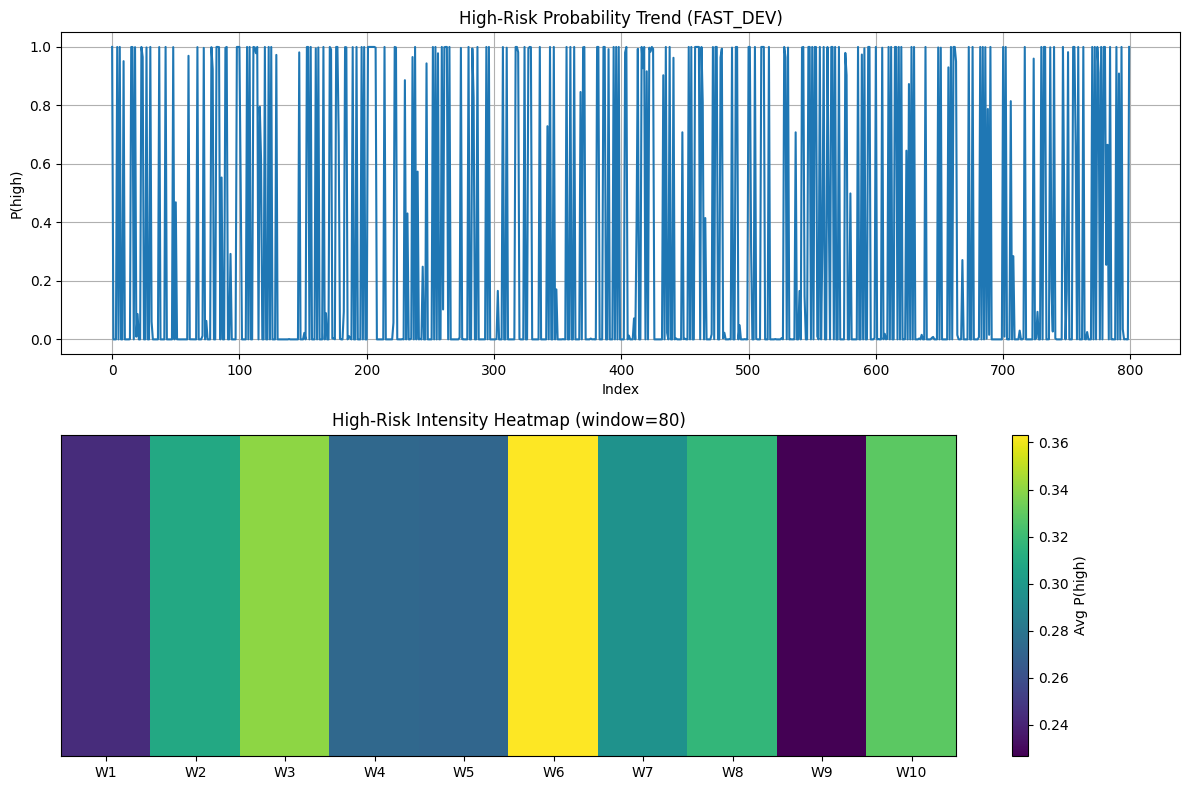


--- Error Analysis (first 10) ---
[1] idx=20
Text: i feel i can only hope im not alone in these thoughts and im sure to all you fellow exchange students you probably have the same thoughts in mind with at least some of this listed some might say being an exchange student is unlike any other experience
True=high_risk Pred=low_risk p=[0.908 0.005 0.086]
--------------------------------------------------------------------------------
[2] idx=24
Text: i hate feeling like this this is bullshit ok i m so done bye
True=low_risk Pred=high_risk p=[0.003 0.031 0.965]
--------------------------------------------------------------------------------
[3] idx=50
Text: i did feel things it was often just repressed fear and anxiety and distrust
True=high_risk Pred=mid_risk p=[0.    0.531 0.469]
--------------------------------------------------------------------------------
[4] idx=74
Text: i feel anger i feel sad i feel joy and i feel other emotions too but will stick to a few
True=high_risk Pred=mid

In [ ]:
# =========================================================
# LLM Emotion → Depression Risk (LoRA) | Colab-ready
# =========================================================
# ✅ 無需 bitsandbytes / triton（不走 QLoRA）
# ✅ 內建類別權重 + EarlyStopping + 線性學習率排程
# ✅ 一鍵快速小跑 / 正式訓練切換
# =========================================================

import os, math, random, json, numpy as np, torch
from datasets import load_dataset, DatasetDict
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, TrainingArguments, Trainer,
                          EarlyStoppingCallback)
from peft import LoraConfig, get_peft_model
from sklearn.metrics import (classification_report, confusion_matrix, f1_score,
                             roc_auc_score, average_precision_score)
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn as nn

# -----------------------
# 環境檢查
# -----------------------
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    import subprocess; print(subprocess.check_output(["nvidia-smi"]).decode())

# -----------------------
# 全域參數
# -----------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ★ 切換快速小跑 / 正式訓練
FAST_DEV = True   # True=小跑；False=正式訓練

# 底模（想更穩、更省顯存，可改成 "Qwen/Qwen2-0.5B"）
MODEL_NAME   = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
MAX_LENGTH   = 96 if FAST_DEV else 120
BATCH_TRAIN  = 4
BATCH_EVAL   = 8
GRAD_ACCUM   = 4
EPOCHS       = 1 if FAST_DEV else 2
LR           = 2e-4
OUTPUT_DIR   = "/content/llm_emotion_risk_lora_final"

# FAST_DEV 的子集大小與訓練步數限制
if FAST_DEV:
    N_TRAIN, N_VAL, N_TEST = 2000, 800, 800
    MAX_STEPS = 600     # 小跑更快看到效果
else:
    N_TRAIN, N_VAL, N_TEST = None, None, None
    MAX_STEPS = -1      # 使用完整 epoch

os.makedirs(OUTPUT_DIR, exist_ok=True)

# -----------------------
# 資料：Emotion → 3 類風險（低/中/高）
# -----------------------
raw_ds = load_dataset("emotion")
label_names = raw_ds["train"].features["label"].names
name_to_risk = {"joy":0, "love":0, "surprise":0, "anger":1, "fear":1, "sadness":2}
id2label = {0: "low_risk", 1: "mid_risk", 2: "high_risk"}

def to_risk(ex):
    ex["risk_label"] = name_to_risk[label_names[ex["label"]]]
    return ex

ds = raw_ds.map(to_risk)

# 取小子集（FAST_DEV）
def take_small(split_name, n):
    d = ds[split_name].shuffle(seed=SEED)
    if n is not None and n < len(d):
        d = d.select(range(n))
    return d

if FAST_DEV:
    ds_small = DatasetDict({
        "train":      take_small("train", N_TRAIN),
        "validation": take_small("validation", N_VAL),
        "test":       take_small("test", N_TEST),
    })
else:
    ds_small = ds

# -----------------------
# Tokenizer（補 pad_token）
# -----------------------
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
if tok.pad_token is None:
    tok.add_special_tokens({"pad_token": tok.eos_token})

def tok_fn(b):
    return tok(b["text"], truncation=True, max_length=MAX_LENGTH, padding=False)

tok_ds = DatasetDict({
    "train":      ds_small["train"].map(tok_fn, batched=True, remove_columns=["text","label"]),
    "validation": ds_small["validation"].map(tok_fn, batched=True, remove_columns=["text","label"]),
    "test":       ds_small["test"].map(tok_fn, batched=True, remove_columns=["text","label"]),
})
tok_ds = tok_ds.rename_column("risk_label", "labels")  # 與 HF 預設對齊
collator = DataCollatorWithPadding(tokenizer=tok, pad_to_multiple_of=8)

# -----------------------
# Base 模型（LoRA，無 bitsandbytes）
# -----------------------
base = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else None,
    device_map="auto" if torch.cuda.is_available() else None
)

# 同步 embedding 與 pad
base.resize_token_embeddings(len(tok))
base.config.pad_token_id = tok.pad_token_id
base.config.use_cache = False
if hasattr(base, "gradient_checkpointing_enable"):
    base.gradient_checkpointing_enable()

# LoRA：省顯存但更有效（q,v,o）
lora_cfg = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["q_proj","v_proj","o_proj"],
    bias="none",
    task_type="SEQ_CLS",
)
model = get_peft_model(base, lora_cfg)
print("Trainable params:"); model.print_trainable_parameters()

# -----------------------
# 指標
# -----------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
    preds = probs.argmax(axis=-1)
    out = {
        "f1_macro":    f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
    }
    try: out["auroc_macro"] = roc_auc_score(labels, probs, multi_class="ovr", average="macro")
    except: out["auroc_macro"] = float("nan")
    try: out["pr_auc_macro"] = average_precision_score(np.eye(3)[labels], probs, average="macro")
    except: out["pr_auc_macro"] = float("nan")
    return out

# -----------------------
# 類別權重（緩解中/高風險不平衡）
# -----------------------
train_labels = np.array(tok_ds["train"]["labels"])
cnt = Counter(train_labels.tolist())
num_classes = 3
freq = np.array([cnt.get(i, 0) for i in range(num_classes)], dtype=float)
class_weights = torch.tensor((freq.sum() / (freq + 1e-9)) / num_classes,
                             dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32)
print("Class weights:", class_weights.tolist())

class WeightedCETrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        w = class_weights.to(logits.device).to(logits.dtype)
        loss = nn.functional.cross_entropy(logits, labels, weight=w)
        return (loss, outputs) if return_outputs else loss

# -----------------------
# 訓練設定（含早停與線性 LR）
# -----------------------
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    # ⚠️ 新版警告：evaluation_strategy 將被棄用，這裡先換成 eval_strategy 以免再跳警告
    eval_strategy="steps",
    eval_steps=200,

    # ✅ 早停需要保存檢查點，並在最後載入最佳模型
    save_strategy="steps",
    save_steps=200,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,

    per_device_train_batch_size=BATCH_TRAIN,
    per_device_eval_batch_size=BATCH_EVAL,
    gradient_accumulation_steps=GRAD_ACCUM,
    num_train_epochs=EPOCHS,
    learning_rate=LR,
    warmup_ratio=0.1,
    weight_decay=0.01,
    lr_scheduler_type="linear",
    bf16=torch.cuda.is_available(),
    fp16=False,
    logging_steps=50,
    report_to="none",
    max_steps=(None if MAX_STEPS == -1 else MAX_STEPS),  # 有設定時會覆蓋 epochs → 正常
    seed=SEED
)


trainer = WeightedCETrainer(
    model=model,
    args=args,
    train_dataset=tok_ds["train"],
    eval_dataset=tok_ds["validation"],
    tokenizer=tok,
    data_collator=collator,
    compute_metrics=compute_metrics
)
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=3))

# -----------------------
# 訓練 / 驗證
# -----------------------
train_out = trainer.train()
val_metrics = trainer.evaluate(tok_ds["validation"])
print("Validation:", json.dumps(val_metrics, indent=2))

# -----------------------
# 測試
# -----------------------
pred = trainer.predict(tok_ds["test"])
logits = pred.predictions
probs  = torch.softmax(torch.tensor(logits), dim=-1).numpy()
y_true = np.array(tok_ds["test"]["labels"])
y_pred = probs.argmax(axis=-1)

res = {
    "f1_macro":    f1_score(y_true, y_pred, average="macro"),
    "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
}
try: res["auroc_macro"] = roc_auc_score(y_true, probs, multi_class="ovr", average="macro")
except: res["auroc_macro"] = float("nan")
try: res["pr_auc_macro"] = average_precision_score(np.eye(3)[y_true], probs, average="macro")
except: res["pr_auc_macro"] = float("nan")
print("Test:", json.dumps(res, indent=2))

print("\n=== Classification Report (Test) ===")
print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(3)], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
print("\nConfusion Matrix:\n", cm)

# -----------------------
# 可視化
# -----------------------
high = probs[:,2]
plt.figure(figsize=(12,8))

plt.subplot(2,1,1)
plt.plot(high)
plt.title("High-Risk Probability Trend" + (" (FAST_DEV)" if FAST_DEV else ""))
plt.xlabel("Index"); plt.ylabel("P(high)"); plt.grid(True)

win = max(20, len(high)//10)
win_means = [high[i*win:(i+1)*win].mean() for i in range((len(high)+win-1)//win)]
heat = np.array(win_means)[None,:]

plt.subplot(2,1,2)
plt.imshow(heat, aspect="auto", cmap="viridis")
plt.colorbar(label="Avg P(high)")
plt.yticks([]); plt.xticks(range(heat.shape[1]), [f"W{i+1}" for i in range(heat.shape[1])])
plt.title(f"High-Risk Intensity Heatmap (window={win})")
plt.tight_layout(); plt.show()

# -----------------------
# 錯誤分析（前 10 筆）
# -----------------------
texts = (ds_small if FAST_DEV else ds)["test"]["text"]
mis = np.where(y_pred != y_true)[0][:10]
print("\n--- Error Analysis (first 10) ---")
for i, idx in enumerate(mis, 1):
    print(f"[{i}] idx={idx}")
    print("Text:", texts[idx][:300].replace("\n"," "))
    print(f"True={id2label[int(y_true[idx])]} Pred={id2label[int(y_pred[idx])]} p={probs[idx].round(3)}")
    print("-"*80)

# -----------------------
# 匯出
# -----------------------
np.save(os.path.join(OUTPUT_DIR, "test_cm.npy"), cm)
with open(os.path.join(OUTPUT_DIR, "test_metrics.json"), "w") as f:
    json.dump(res, f, indent=2)
from pathlib import Path
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
trainer.save_model(OUTPUT_DIR)
tok.save_pretrained(OUTPUT_DIR)
print("Saved to:", OUTPUT_DIR)
